# MetroFlow 客流特征规律与出行模式综合分析
## 基于上海地铁2017年5-8月数据的系统性分析

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime
from chinese_calendar import is_workday, is_holiday
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

## 1. 数据加载与预处理

In [2]:
# 加载数据
inout_data = pd.read_csv('../Data/metroData_InOutFlow.csv')
od_data = pd.read_csv('../Data/metroData_ODFlow.csv')
station_info = pd.read_csv('../Data/stationInfo.csv')

print(f"进出站数据: {inout_data.shape}")
print(f"OD数据: {od_data.shape}")
print(f"站点信息: {station_info.shape}")

# 创建站点映射字典
station_name_dict = dict(zip(station_info['stationID'], station_info['name']))
station_loc_dict = dict(zip(station_info['stationID'], 
                           zip(station_info['lon'], station_info['lat'])))
station_list = list(station_info['stationID'])

进出站数据: (3788892, 13)
OD数据: (267318222, 10)
站点信息: (302, 6)


## 2. 时间维度分析
### 2.1 日内时间模式分析

100%|██████████| 3788892/3788892 [00:04<00:00, 800069.40it/s]


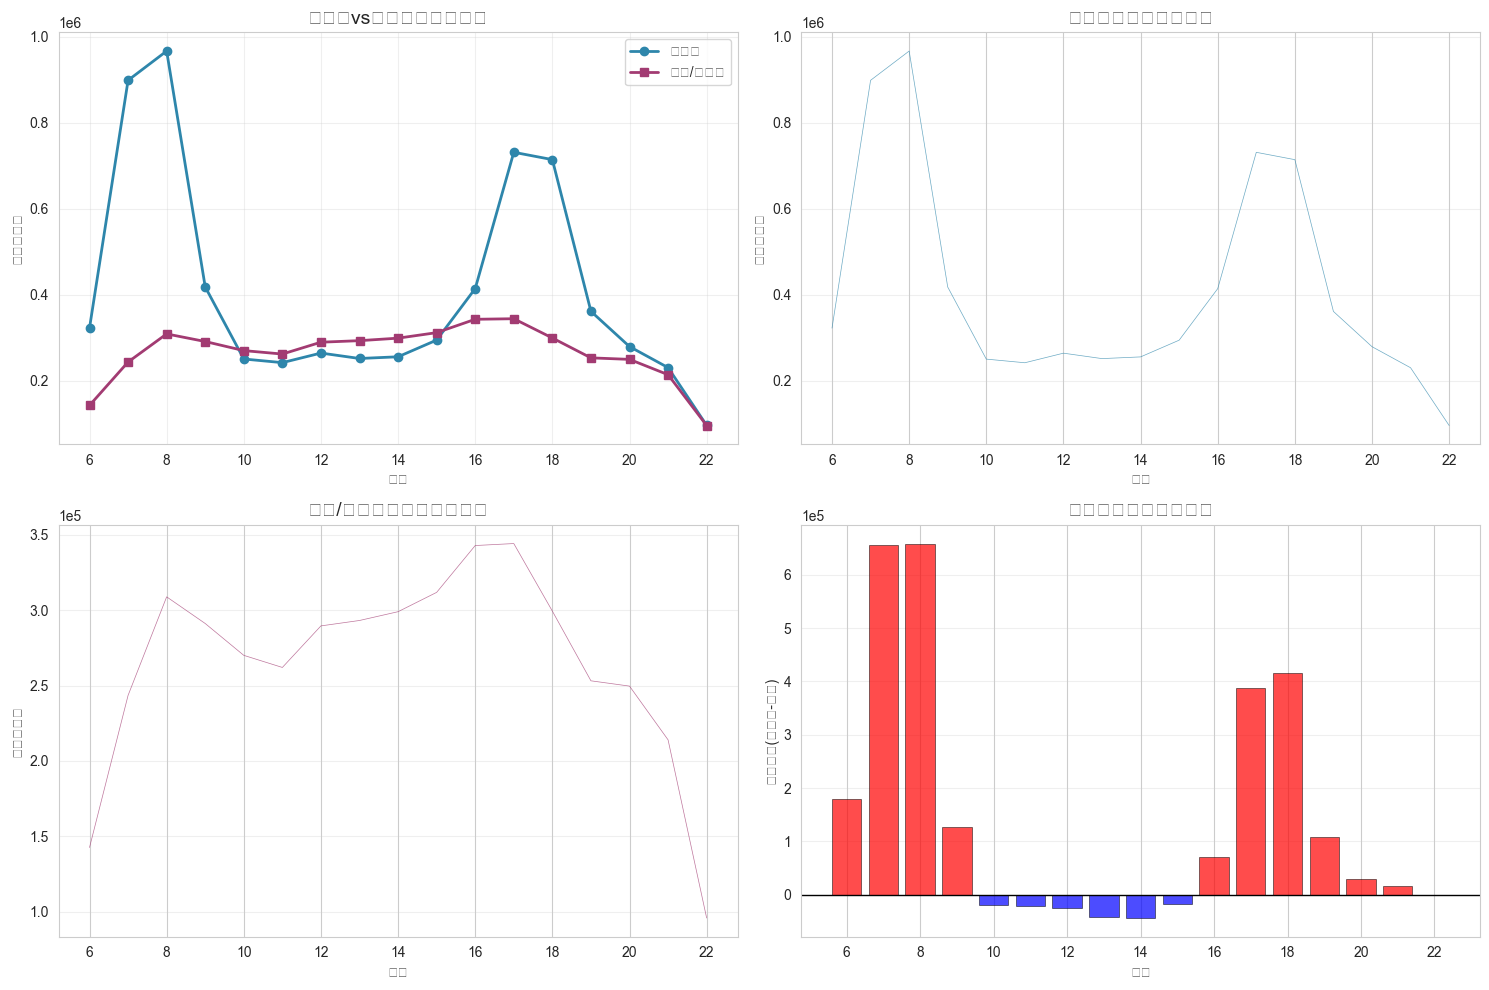

=== 时间模式分析结果 ===
工作日客流最高峰: 967088人次 (第8时)
周末客流最高峰: 344204人次 (第17时)
工作日日均总客流: 6993094人次
周末日均总客流: 4510367人次
工作日高峰时段: [7, 8, 17, 18]


In [11]:
def analyze_hourly_patterns():
    """分析24小时客流模式"""
    
    WorkdayResults = {}
    HolidayResults = {}
    start_hour = 6 # start from 6:00
    end_hour = 23  # end in 23:00

    for i in range(start_hour, end_hour):
        WorkdayResults[i] = []
        HolidayResults[i] = []

    curr_date = 20170501
    abnormal_date = [20170504, 20170508, 20170509, 20170616, 20170627, 20170628]
    date_cache = [ 0 for i in range(end_hour - start_hour)]# 每天从6点到23点每个小时的流入量缓存

    for line in tqdm(inout_data.values):
        if line [0] in abnormal_date:
            continue
        if curr_date != line[0]:
            if is_workday(datetime.datetime.strptime(str(curr_date),"%Y%m%d")):
                for hour in range(end_hour - start_hour):
                    WorkdayResults[hour+start_hour].append(date_cache[hour])
            else:
                for hour in range(end_hour - start_hour):
                    HolidayResults[hour+start_hour].append(date_cache[hour])
            
            curr_date = line [0]
            date_cache = [ 0 for i in range(end_hour - start_hour)]

        curr_hour = line[2]//10000
        if curr_hour >= start_hour and curr_hour < end_hour:
            date_cache[curr_hour - start_hour] += line[5]# 累加当前小时的流入量
    
    # Last Day
    if is_workday(datetime.datetime.strptime(str(curr_date),"%Y%m%d")):
        for hour in range(end_hour - start_hour):
            WorkdayResults[hour+start_hour].append(date_cache[hour])
    else:
        for hour in range(end_hour - start_hour):
            HolidayResults[hour+start_hour].append(date_cache[hour])
    
    # 计算每小时的平均客流量
    workday_hourly_mean = {}
    weekend_hourly_mean = {}
    
    for hour in range(start_hour, end_hour):
        workday_hourly_mean[hour] = np.mean(WorkdayResults[hour]) if WorkdayResults[hour] else 0
        weekend_hourly_mean[hour] = np.mean(HolidayResults[hour]) if HolidayResults[hour] else 0
    
    # 转换为DataFrame格式以便后续分析
    workday_hourly = pd.DataFrame({
        'hour': list(workday_hourly_mean.keys()),
        'inFlow': list(workday_hourly_mean.values())
    }).set_index('hour')
    
    weekend_hourly = pd.DataFrame({
        'hour': list(weekend_hourly_mean.keys()),
        'inFlow': list(weekend_hourly_mean.values())
    }).set_index('hour')
    
    # 可视化分析
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 工作日vs周末对比
    hours = list(range(start_hour, end_hour))
    workday_flows = [workday_hourly_mean[h] for h in hours]
    weekend_flows = [weekend_hourly_mean[h] for h in hours]
    
    axes[0,0].plot(hours, workday_flows, label='工作日', marker='o', linewidth=2, color='#2E86AB')
    axes[0,0].plot(hours, weekend_flows, label='周末/节假日', marker='s', linewidth=2, color='#A23B72')
    axes[0,0].set_title('工作日vs周末小时客流对比', fontsize=14)
    axes[0,0].set_xlabel('小时')
    axes[0,0].set_ylabel('平均客流量')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xticks(range(6, 23, 2))
    axes[0,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 工作日客流分布
    axes[0,1].plot(hours, workday_flows, alpha=0.7, color='#2E86AB', linewidth=0.5)
    axes[0,1].set_title('工作日各时段客流分布', fontsize=14)
    axes[0,1].set_xlabel('小时')
    axes[0,1].set_ylabel('平均客流量')
    axes[0,1].grid(True, alpha=0.3, axis='y')
    axes[0,1].set_xticks(range(6, 23, 2))
    axes[0,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 周末客流分布
    axes[1,0].plot(hours, weekend_flows, alpha=0.7, color='#A23B72', linewidth=0.5)
    axes[1,0].set_title('周末/节假日各时段客流分布', fontsize=14)
    axes[1,0].set_xlabel('小时')
    axes[1,0].set_ylabel('平均客流量')
    axes[1,0].grid(True, alpha=0.3, axis='y')
    axes[1,0].set_xticks(range(6, 23, 2))
    axes[1,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 工作日vs周末的差异分析
    flow_diff = [workday_flows[i] - weekend_flows[i] for i in range(len(hours))]
    colors = ['red' if x > 0 else 'blue' for x in flow_diff]
    axes[1,1].bar(hours, flow_diff, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[1,1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1,1].set_title('工作日与周末客流差异', fontsize=14)
    axes[1,1].set_xlabel('小时')
    axes[1,1].set_ylabel('客流差异(工作日-周末)')
    axes[1,1].grid(True, alpha=0.3, axis='y')
    axes[1,1].set_xticks(range(6, 23, 2))
    axes[1,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.savefig('../results/hourly_patterns.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 输出统计信息
    print("=== 时间模式分析结果 ===")
    print(f"工作日客流最高峰: {max(workday_flows):.0f}人次 (第{hours[workday_flows.index(max(workday_flows))]}时)")
    print(f"周末客流最高峰: {max(weekend_flows):.0f}人次 (第{hours[weekend_flows.index(max(weekend_flows))]}时)")
    print(f"工作日日均总客流: {sum(workday_flows):.0f}人次")
    print(f"周末日均总客流: {sum(weekend_flows):.0f}人次")
    
    # 识别高峰时段
    workday_peak_hours = [h for h, f in zip(hours, workday_flows) if f > np.mean(workday_flows) + np.std(workday_flows)]
    print(f"工作日高峰时段: {workday_peak_hours}")
    
    return workday_hourly, weekend_hourly
    
#     # 按小时聚合客流数据
#     hourly_flow = inout_data.groupby(['date', 'hour']).agg({
#         'inFlow': 'sum',
#         'outFlow': 'sum'
#     }).reset_index()
    
#     # 添加工作日标识
#     hourly_flow['is_workday'] = hourly_flow['date'].apply(
#         lambda x: is_workday(datetime.datetime.strptime(str(x), '%Y%m%d'))
#     )
    
#     # 分别计算工作日和周末的小时均值
#     workday_hourly = hourly_flow[hourly_flow['is_workday']].groupby('hour').agg({
#         'inFlow': 'mean',
#         'outFlow': 'mean'
#     })
    
#     weekend_hourly = hourly_flow[~hourly_flow['is_workday']].groupby('hour').agg({
#         'inFlow': 'mean', 
#         'outFlow': 'mean'
#     })
    
#     # 可视化
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
#     # 工作日模式
#     axes[0,0].plot(workday_hourly.index, workday_hourly['inFlow'], 
#                    label='进站', marker='o', linewidth=2)
#     axes[0,0].plot(workday_hourly.index, workday_hourly['outFlow'], 
#                    label='出站', marker='s', linewidth=2)
#     axes[0,0].set_title('工作日小时客流模式', fontsize=14)
#     axes[0,0].set_xlabel('小时')
#     axes[0,0].set_ylabel('平均客流量')
#     axes[0,0].legend()
#     axes[0,0].grid(True, alpha=0.3)
    
#     # 周末模式
#     axes[0,1].plot(weekend_hourly.index, weekend_hourly['inFlow'], 
#                    label='进站', marker='o', linewidth=2)
#     axes[0,1].plot(weekend_hourly.index, weekend_hourly['outFlow'], 
#                    label='出站', marker='s', linewidth=2)
#     axes[0,1].set_title('周末小时客流模式', fontsize=14)
#     axes[0,1].set_xlabel('小时')
#     axes[0,1].set_ylabel('平均客流量')
#     axes[0,1].legend()
#     axes[0,1].grid(True, alpha=0.3)
    
#     # 进出站不平衡分析
#     workday_imbalance = (workday_hourly['inFlow'] - workday_hourly['outFlow']) / workday_hourly['inFlow']
#     weekend_imbalance = (weekend_hourly['inFlow'] - weekend_hourly['outFlow']) / weekend_hourly['inFlow']
    
#     axes[1,0].bar(workday_imbalance.index, workday_imbalance.values, 
#                   alpha=0.7, color='skyblue')
#     axes[1,0].axhline(y=0, color='red', linestyle='--')
#     axes[1,0].set_title('工作日进出站不平衡指数', fontsize=14)
#     axes[1,0].set_xlabel('小时')
#     axes[1,0].set_ylabel('不平衡指数')
    
#     axes[1,1].bar(weekend_imbalance.index, weekend_imbalance.values, 
#                   alpha=0.7, color='lightgreen')
#     axes[1,1].axhline(y=0, color='red', linestyle='--')
#     axes[1,1].set_title('周末进出站不平衡指数', fontsize=14)
#     axes[1,1].set_xlabel('小时')
#     axes[1,1].set_ylabel('不平衡指数')
    
#     plt.tight_layout()
#     plt.savefig('../results/hourly_patterns.pdf', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     return workday_hourly, weekend_hourly

workday_hourly, weekend_hourly = analyze_hourly_patterns()

### 2.2 高峰特征量化分析

In [12]:
def analyze_peak_characteristics(workday_hourly):
    """量化高峰时段特征"""
    
    total_daily_inflow = workday_hourly['inFlow'].sum()
    
    # 早高峰分析 (7-9点)
    morning_peak_flow = workday_hourly.loc[7:9, 'inFlow'].sum()
    morning_peak_ratio = morning_peak_flow / total_daily_inflow
    
    # 晚高峰分析 (17-19点)
    evening_peak_flow = workday_hourly.loc[17:19, 'inFlow'].sum()
    evening_peak_ratio = evening_peak_flow / total_daily_inflow
    
    # 高峰集中度计算
    peak_hours_flow = morning_peak_flow + evening_peak_flow
    peak_concentration = peak_hours_flow / total_daily_inflow
    
    
    print("=== 高峰特征分析结果 ===")
    print(f"早高峰客流占比: {morning_peak_ratio:.2%}")
    print(f"晚高峰客流占比: {evening_peak_ratio:.2%}")
    print(f"双高峰集中度: {peak_concentration:.2%}")

    
    return {
        'morning_peak_ratio': morning_peak_ratio,
        'evening_peak_ratio': evening_peak_ratio,
        'peak_concentration': peak_concentration,
        
    }

peak_stats = analyze_peak_characteristics(workday_hourly)

=== 高峰特征分析结果 ===
早高峰客流占比: 32.66%
晚高峰客流占比: 25.85%
双高峰集中度: 58.51%


## 3. 空间维度分析
### 3.1 站点客流特征分析

In [10]:
def analyze_station_characteristics():
    """分析站点客流特征和分类"""
    
    # 计算各站点的基本统计特征
    station_stats = inout_data.groupby('stationID').agg({
        'inFlow': ['sum', 'mean', 'std'],
        'outFlow': ['sum', 'mean', 'std']
    }).reset_index()
    
    # 展平列名
    station_stats.columns = ['stationID', 'inFlow_sum', 'inFlow_mean', 'inFlow_std',
                            'outFlow_sum', 'outFlow_mean', 'outFlow_std']
    
    # 计算衍生指标
    station_stats['total_flow'] = station_stats['inFlow_sum'] + station_stats['outFlow_sum']
    station_stats['flow_imbalance'] = (station_stats['inFlow_sum'] - station_stats['outFlow_sum']) / station_stats['total_flow']
    station_stats['flow_variability'] = (station_stats['inFlow_std'] + station_stats['outFlow_std']) / (station_stats['inFlow_mean'] + station_stats['outFlow_mean'])
    
    # 添加站点名称
    station_stats['station_name'] = station_stats['stationID'].map(station_name_dict)
    
    # 可视化分析
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 客流量分布
    axes[0,0].hist(station_stats['total_flow'], bins=30, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('站点总客流量分布', fontsize=14)
    axes[0,0].set_xlabel('总客流量')
    axes[0,0].set_ylabel('站点数量')
    axes[0,0].axvline(station_stats['total_flow'].median(), color='red', linestyle='--', label='中位数')
    axes[0,0].legend()
    
    # 进出站不平衡分布
    axes[0,1].hist(station_stats['flow_imbalance'], bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('站点进出站不平衡分布', fontsize=14)
    axes[0,1].set_xlabel('不平衡指数')
    axes[0,1].set_ylabel('站点数量')
    axes[0,1].axvline(0, color='red', linestyle='--', label='平衡线')
    axes[0,1].legend()
    
    # 客流量vs不平衡散点图
    scatter = axes[1,0].scatter(station_stats['total_flow'], station_stats['flow_imbalance'], 
                               alpha=0.6, s=50)
    axes[1,0].set_title('客流量与进出站不平衡关系', fontsize=14)
    axes[1,0].set_xlabel('总客流量')
    axes[1,0].set_ylabel('不平衡指数')
    axes[1,0].axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # Top20高客流站点
    top20_stations = station_stats.nlargest(20, 'total_flow')
    y_pos = np.arange(len(top20_stations))
    axes[1,1].barh(y_pos, top20_stations['total_flow'], alpha=0.7)
    axes[1,1].set_yticks(y_pos)
    axes[1,1].set_yticklabels(top20_stations['station_name'], fontsize=10)
    axes[1,1].set_title('客流量Top20站点', fontsize=14)
    axes[1,1].set_xlabel('总客流量')
    
    plt.tight_layout()
    plt.savefig('../results/station_characteristics.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return station_stats

station_stats = analyze_station_characteristics()

KeyError: 'stationID'

### 3.2 站点功能分类

In [ ]:
def classify_station_functions(station_stats):
    """基于客流特征对站点进行功能分类"""
    
    # 选择分类特征
    features = ['total_flow', 'flow_imbalance', 'flow_variability']
    X = station_stats[features].values
    
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means聚类
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    station_stats['cluster'] = kmeans.fit_predict(X_scaled)
    
    # 为聚类分配功能标签
    cluster_labels = {}
    for i in range(n_clusters):
        cluster_data = station_stats[station_stats['cluster'] == i]
        avg_flow = cluster_data['total_flow'].mean()
        avg_imbalance = cluster_data['flow_imbalance'].mean()
        
        if avg_flow > station_stats['total_flow'].quantile(0.75):
            if avg_imbalance > 0.1:
                cluster_labels[i] = '商务核心区'
            elif avg_imbalance < -0.1:
                cluster_labels[i] = '居住核心区'
            else:
                cluster_labels[i] = '综合枢纽'
        else:
            cluster_labels[i] = '一般站点'
    
    station_stats['function_type'] = station_stats['cluster'].map(cluster_labels)
    
    # 可视化聚类结果
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 散点图显示聚类
    colors = ['red', 'blue', 'green', 'orange']
    for i, func_type in enumerate(cluster_labels.values()):
        cluster_data = station_stats[station_stats['function_type'] == func_type]
        axes[0].scatter(cluster_data['total_flow'], cluster_data['flow_imbalance'], 
                       c=colors[i], label=func_type, alpha=0.7, s=50)
    
    axes[0].set_xlabel('总客流量')
    axes[0].set_ylabel('进出站不平衡指数')
    axes[0].set_title('站点功能分类结果')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 各类型站点数量统计
    type_counts = station_stats['function_type'].value_counts()
    axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[1].set_title('各功能类型站点占比')
    
    plt.tight_layout()
    plt.savefig('../results/station_classification.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 输出各类型的代表性站点
    print("=== 站点功能分类结果 ===")
    for func_type in cluster_labels.values():
        type_stations = station_stats[station_stats['function_type'] == func_type]
        top_stations = type_stations.nlargest(5, 'total_flow')['station_name'].tolist()
        print(f"{func_type} ({len(type_stations)}个): {', '.join(top_stations[:3])}...")
    
    return station_stats

station_stats = classify_station_functions(station_stats)

## 4. 出行距离与时间分析

In [ ]:
def analyze_trip_patterns():
    """分析出行距离和时间模式"""
    
    # 从OD数据中提取出行信息
    if 'tripCount' in od_data.columns:
        # 计算出行距离（简化为欧几里得距离）
        trip_distances = []
        trip_counts = []
        
        for _, row in tqdm(od_data.iterrows(), total=len(od_data)):
            origin_id = row['inStationID']
            dest_id = row['outStationID']
            count = row['tripCount']
            
            if origin_id in station_loc_dict and dest_id in station_loc_dict:
                orig_loc = station_loc_dict[origin_id]
                dest_loc = station_loc_dict[dest_id]
                
                # 计算欧几里得距离（简化）
                distance = np.sqrt((orig_loc[0] - dest_loc[0])**2 + 
                                 (orig_loc[1] - dest_loc[1])**2) * 111  # 转换为km
                
                trip_distances.append(distance)
                trip_counts.append(count)
        
        # 可视化出行距离分布
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 距离分布直方图
        axes[0,0].hist(trip_distances, bins=50, alpha=0.7, edgecolor='black', weights=trip_counts)
        axes[0,0].set_title('出行距离分布（按出行量加权）')
        axes[0,0].set_xlabel('距离 (km)')
        axes[0,0].set_ylabel('出行量')
        
        # 距离分布箱线图
        axes[0,1].boxplot(trip_distances, vert=True)
        axes[0,1].set_title('出行距离分布特征')
        axes[0,1].set_ylabel('距离 (km)')
        
        # 距离-频次散点图
        axes[1,0].scatter(trip_distances, trip_counts, alpha=0.5, s=10)
        axes[1,0].set_xlabel('距离 (km)')
        axes[1,0].set_ylabel('出行次数')
        axes[1,0].set_title('距离与出行频次关系')
        axes[1,0].set_yscale('log')
        
        # 累积分布函数
        sorted_distances = np.sort(trip_distances)
        cumulative_prob = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
        axes[1,1].plot(sorted_distances, cumulative_prob, linewidth=2)
        axes[1,1].set_xlabel('距离 (km)')
        axes[1,1].set_ylabel('累积概率')
        axes[1,1].set_title('出行距离累积分布')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../results/trip_distance_analysis.pdf', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 计算描述性统计
        distance_stats = {
            'mean': np.average(trip_distances, weights=trip_counts),
            'median': np.median(trip_distances),
            'std': np.sqrt(np.average((trip_distances - np.average(trip_distances, weights=trip_counts))**2, weights=trip_counts)),
            'q25': np.percentile(trip_distances, 25),
            'q75': np.percentile(trip_distances, 75)
        }
        
        print("=== 出行距离统计特征 ===")
        print(f"平均距离: {distance_stats['mean']:.2f} km")
        print(f"中位数距离: {distance_stats['median']:.2f} km")
        print(f"标准差: {distance_stats['std']:.2f} km")
        print(f"25%分位数: {distance_stats['q25']:.2f} km")
        print(f"75%分位数: {distance_stats['q75']:.2f} km")
        
        return distance_stats
    else:
        print("OD数据中缺少tripCount字段，无法进行出行模式分析")
        return None

trip_stats = analyze_trip_patterns()

## 5. 综合分析报告生成

In [ ]:
def generate_comprehensive_report(peak_stats, station_stats, trip_stats):
    """生成综合分析报告"""
    
    print("="*60)
    print("        上海地铁客流特征规律综合分析报告")
    print("="*60)
    
    print("\n🕐 时间维度特征:")
    print(f"  • 早高峰集中度: {peak_stats['morning_peak_ratio']:.1%}")
    print(f"  • 晚高峰集中度: {peak_stats['evening_peak_ratio']:.1%}")
    print(f"  • 双高峰总集中度: {peak_stats['peak_concentration']:.1%}")
    print(f"  • 峰谷差异倍数: {peak_stats['peak_valley_ratio']:.1f}倍")
    
    print("\n🚇 空间维度特征:")
    print(f"  • 站点总数: {len(station_stats)}个")
    print(f"  • 平均单站日客流: {station_stats['total_flow'].mean():.0f}人次")
    print(f"  • 客流量标准差: {station_stats['total_flow'].std():.0f}人次")
    print(f"  • 最高客流站点: {station_stats.loc[station_stats['total_flow'].idxmax(), 'station_name']}")
    
    print("\n🏢 站点功能分布:")
    func_counts = station_stats['function_type'].value_counts()
    for func_type, count in func_counts.items():
        percentage = count / len(station_stats) * 100
        print(f"  • {func_type}: {count}个 ({percentage:.1f}%)")
    
    if trip_stats:
        print("\n🛤️ 出行模式特征:")
        print(f"  • 平均出行距离: {trip_stats['mean']:.2f} km")
        print(f"  • 中位数出行距离: {trip_stats['median']:.2f} km")
        print(f"  • 出行距离标准差: {trip_stats['std']:.2f} km")
        print(f"  • 50%的出行距离在: {trip_stats['q25']:.2f}-{trip_stats['q75']:.2f} km之间")
    
    print("\n📊 关键发现:")
    print(f"  • 典型的双高峰通勤模式，高峰期承载{peak_stats['peak_concentration']:.0%}的日客流")
    print(f"  • 站点客流分布不均，标准差达到平均值的{station_stats['total_flow'].std()/station_stats['total_flow'].mean():.0%}")
    print(f"  • {func_counts.get('商务核心区', 0)}个商务核心区和{func_counts.get('居住核心区', 0)}个居住核心区形成主要通勤流")
    
    if trip_stats and trip_stats['mean'] < 15:
        print(f"  • 出行距离相对较短，平均{trip_stats['mean']:.1f}km，体现了地铁作为城市内部交通的特征")
    
    print("\n💡 运营建议:")
    print("  • 在早晚高峰时段增加发车频次，重点关注商务-居住区间的客流走廊")
    print("  • 对高客流站点加强客流疏导和安全管理")
    print("  • 利用非高峰时段进行设备维护和线路检修")
    print("  • 考虑在综合枢纽站点增设换乘便民设施")
    
    print("\n" + "="*60)

generate_comprehensive_report(peak_stats, station_stats, trip_stats)

## 6. 保存分析结果

In [ ]:
# 保存关键分析结果
station_stats.to_csv('../results/station_characteristics_analysis.csv', index=False)
workday_hourly.to_csv('../results/hourly_patterns_workday.csv')
weekend_hourly.to_csv('../results/hourly_patterns_weekend.csv')

print("分析结果已保存到 ../results/ 目录")
print("\n生成的文件:")
print("• station_characteristics_analysis.csv - 站点特征分析结果")
print("• hourly_patterns_workday.csv - 工作日小时客流模式")
print("• hourly_patterns_weekend.csv - 周末小时客流模式")
print("• hourly_patterns.pdf - 时间模式可视化")
print("• station_characteristics.pdf - 站点特征可视化")
print("• station_classification.pdf - 站点分类结果")
print("• trip_distance_analysis.pdf - 出行距离分析")